# Simulation Demonstration

This notebook demonstrates the construction of a control system using the node based model, and the simulation of the system.

In [105]:
#importing the simulation, filterer, controller and agent classes
import sys
import math
import sympy
sys.path.append('../')

## Reference Signal Node

In [106]:
from humancompatible.interconnect.simulators.nodes.reference import ReferenceSignal
refSig = ReferenceSignal(name="r")
refSig.set_reference_signal(0.5)

## Aggregator Node

Aggregator nodes are the only node that can accept a many to one connection. They will combine these signals into a single signal.

Logic is controlled by a logic class. For the aggregator node, this requires the following:
- `self.constants`: a dictionary of constants that are used in the logic
- `self.aggregation_function`: a function that takes in a list of signals and returns a single signal, where `args` is a list of signals


In [107]:
class AggregatorLogic:
    def __init__(self):
        self.constants = {}
        
    def aggregation_function(self, signalList):
        #takes a list of values, and needs to return a single summary value
        return sum(signalList)

from humancompatible.interconnect.simulators.nodes.aggregator import Aggregator
agg1 = Aggregator(name="A1", logic=AggregatorLogic())
agg2 = Aggregator(name="A2", logic=AggregatorLogic())

## Controller Node

#### Creating New Logic Classes for Controllers

##### Overview

To create a new logic class for use with the `Controller` class, follow these guidelines. Your logic class should define the behavior of a specific type of controller (e.g., PI, PID, MPC).

##### Requirements

Each logic class must have:

1. An `input_variables` attribute: A list of input variable names, provided by the input signal from the prior node.
2. An `evaluate(variable_values)` method: Computes and returns the controller output.

##### Basic Structure

```python
class YourLogicClass:
    def __init__(self, param1=default1, param2=default2):
        self.input_variables = ["input1", "input2", ...]
        # Initialize other necessary attributes

    def evaluate(self, variable_values):
        # Compute the output based on input values
        # Update internal state if necessary
        return output
```
Any information needed to be stored between cycles can also be stored in the logic class. This can be done by adding attributes to the class and updating them in the `evaluate` method.

Prewritten logic classes can be found in the `interconnect/simulators/logic/controllers` directory. New logic classes should be added to this directory if they would be useful for other users.

In [108]:
from humancompatible.interconnect.simulators.nodes.controller import Controller

class PIControllerLogic:
    def __init__(self, kappa=0.5, alpha=0.1, sp = 0.0):
        self.input_variables = ["signal"]
        
        self.pi_prev = sympy.Symbol("pi_prev")
        self.e = sympy.Symbol("e")
        self.e_prev = sympy.Symbol("e_prev")
        self.kappa = sympy.Symbol("kappa")
        self.alpha = sympy.Symbol("alpha")
        self.sp = sympy.Symbol("sp")
        
        self.expression = (
            self.pi_prev + self.kappa * (self.e - self.alpha * self.e_prev)
        )

        self.constants = {self.kappa: kappa, self.alpha: alpha, self.sp: sp}

        self.state = {self.pi_prev: 0, self.e_prev: 0}

    def evaluate(self, variable_values):
        self.state[self.e] = self.sp - variable_values["signal"]
        
        result = self.expression.subs(self.state).subs(self.constants)
        
        output = float(result)

        self.state[self.e_prev] = self.state[self.e]
        self.state[self.pi_prev] = output
        
        return output

cont = Controller(name="C", logic=PIControllerLogic())

## Population Node

A node that represents a population of agents. Takes a logic object, along with a number of agents and the positive and negative feedback signals. This logic will be applied to each agent in the population. In order to use multiple types of agents, multiple population nodes can be used in parallel, and joined with an aggregator node.

In [109]:
from humancompatible.interconnect.simulators.nodes.population import Population

class AgentLogic1:
    def __init__(self):
        x, startThreshold, endThreshold = sympy.symbols('x startThreshold endThreshold')
        self.symbols = {"x": x, "startThreshold": startThreshold, "endThreshold": endThreshold}
        self.constants = {"startThreshold": -80, "endThreshold": 80}
        self.variables = ["x"]
        self.expression = sympy.Piecewise(
            (0, self.symbols["x"] < self.symbols["startThreshold"]),
            (1, self.symbols["x"] > self.symbols["endThreshold"]),
            ((1 + sympy.cos(sympy.pi * (self.symbols["x"] - self.symbols["endThreshold"]) / (self.symbols["startThreshold"] - self.symbols["endThreshold"]))) / 2, True)
        )

pop1 = Population(name="P1", 
                logic=AgentLogic1(), 
                number_of_agents=100000, 
                positive_response=1, 
                negative_response=0)

class AgentLogic2:
    def __init__(self):
        x, startThreshold, endThreshold = sympy.symbols('x startThreshold endThreshold')
        self.symbols = {"x": x, "startThreshold": startThreshold, "endThreshold": endThreshold}
        self.constants = {"startThreshold": -20, "endThreshold": 20}
        self.variables = ["x"]
        self.expression = sympy.Piecewise(
            (0, self.symbols["x"] < self.symbols["startThreshold"]),
            (1, self.symbols["x"] > self.symbols["endThreshold"]),
            ((1 + sympy.cos(sympy.pi * (self.symbols["x"] - self.symbols["endThreshold"]) / (self.symbols["startThreshold"] - self.symbols["endThreshold"]))) / 2, True)
        )

pop2 = Population(name="P2", 
                logic=AgentLogic2(), 
                number_of_agents=100000, 
                positive_response=1, 
                negative_response=0)

## Delay Node

In [110]:
from humancompatible.interconnect.simulators.nodes.delay import Delay
delay = Delay(name="Z", time=1)

## Filterer Node

Filterer nodes take a logic  object. For the controller, this requires the following:

- `self.symbols`: a dictionary of symbols that are used in the logic, uses the `sympy` library
- `self.constants`: a dictionary of constants that are used in the logic
- `self.variables`: a list of variables that are used in the logic, in the order that they are passed to the node
- `self.expression`: a sympy expression that is used to calculate the output signal

In [111]:
from humancompatible.interconnect.simulators.nodes.filterer import Filterer

class filtererLogic():
    def __init__(self):
        self.symbols = {"S":sympy.Symbol("S"),
                        "K":sympy.Symbol("K")}
        self.constants = {"K":2}
        self.variables = ["S"]
        self.expression = (self.symbols["S"]+1)/self.symbols["K"]

fil = Filterer(name="F", logic=filtererLogic())

## Simulation

In [112]:
from humancompatible.interconnect.simulators.simulation import Simulation
sim = Simulation()

### Creating the system

The system is composed of a number of nodes.

Single nodes can be added using the `system.add_node` method. Multiple nodes can be added using the `system.add_nodes` method, where a list of nodes is passed as an argument.

To connect nodes, the `system.connect` method is used. This method takes two arguments, the first being the source node and the second being the target node.

The start node, where the process begins, and the checkpoint node, where an iteration is considered complete, are added using the `system.add_start` and `system.add_checkpoint` methods, respectively.

In [113]:
sim.system.add_nodes([refSig, agg1, cont, pop1, pop2, agg2, delay, fil])
sim.system.connect_nodes(refSig, agg1)
sim.system.connect_nodes(agg1, cont)
sim.system.connect_nodes(cont, pop1)
sim.system.connect_nodes(pop1, agg2)
sim.system.connect_nodes(cont, pop2)
sim.system.connect_nodes(pop2, agg2)
sim.system.connect_nodes(agg2, delay)
sim.system.connect_nodes(delay, fil)
sim.system.connect_nodes(fil, agg1)

sim.system.set_start_node(refSig)
sim.system.set_checkpoint_node(agg1)

### Rendering the system graph

Calling the `system.render_graph()` method will produce a visualisation of the control system. This is useful for ensuring that the system has been constructed according to the desired configuration.

The start node, shaded in green, indicates where the process will begin.

The checkpoint node, shaded in blue, indicates where the iteration count will be incremented. Typically, this will be the first node in the circular path of the system.

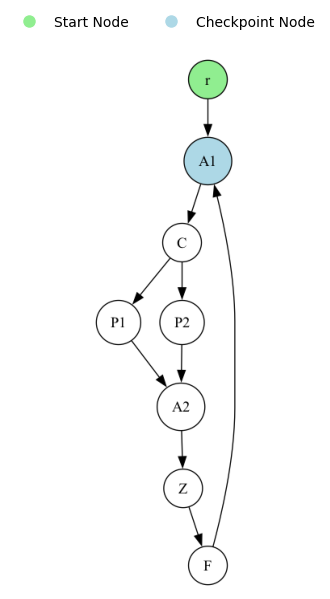

In [114]:
sim.plot.render_graph()

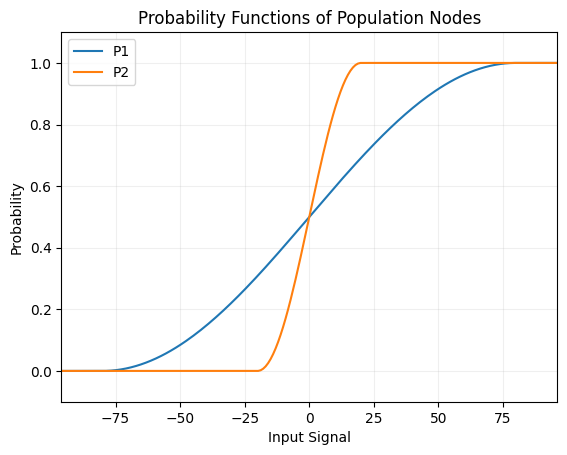

In [115]:
sim.plot.population_probabilities()

### Checking the validity of the system

This is automatically done prior to running the simulation, but it can be done manually by calling the `check_system` method.

In [116]:
validSystem = sim.system.check_system()
if validSystem:
    print("System is valid")
else:
    for e in validSystem:
        print(e)

System is valid


### Running the simulation

In [117]:
sim.system.run(100, showTrace=False)

Running Control System: 101it [00:00, 236.60it/s]                        


### Plotting Node History

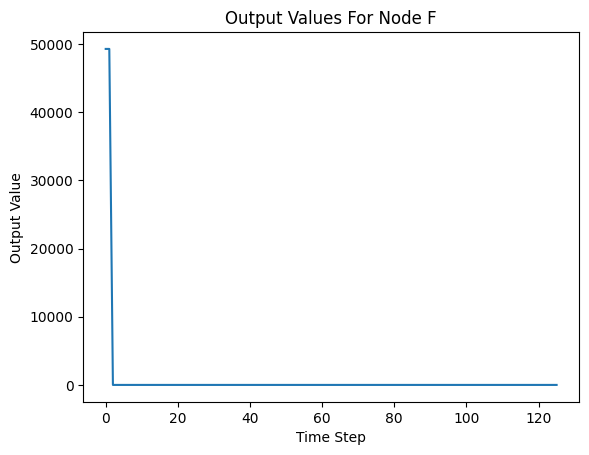

In [118]:
sim.plot.node_outputs(fil)

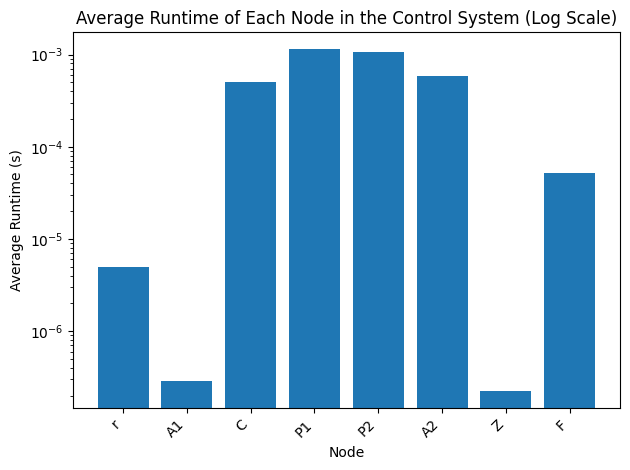

In [119]:
sim.plot.runtimes()